# Exploratory Data Analysis

**Dataset:** `data/news_segmented.jsonl.gz`  
**Articles:** 2020–2025 financial news, sentence-split & cleaned  
**Goal:** Understand corpus structure, ticker/sector distribution, temporal and text‐level patterns.


In [1]:
# 1. Imports & Settings
import gzip, json
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import nltk
from collections import Counter
from itertools import combinations
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, numpy as np

sns.set_theme(style="whitegrid")
pd.set_option("display.max_colwidth", 100)


c:\Users\roee1\OneDrive\Desktop\fin‑sentiment\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert").to(device)
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

print("FinBERT ready on", device)

c:\Users\roee1\OneDrive\Desktop\fin‑sentiment\venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\roee1\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regu

FinBERT ready on cpu


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


## 2. Load Data


In [3]:
# 2.1 Sample load for fast prototyping (first 100 k)
records = []
with gzip.open("../data/news_cleaned.jsonl.gz","rt",encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 100_000: break
        records.append(json.loads(line))
df = pd.DataFrame(records)
print("Sample shape:", df.shape)



Sample shape: (100000, 5)


In [4]:
# 2.2 Full‐set count
total = sum(1 for _ in gzip.open("../data/news_cleaned.jsonl.gz","rt",encoding="utf-8"))
print("Total articles:", total)


Total articles: 1566700


## 3. Corpus-Level Statistics


In [5]:
# 3.1 Sentences/article and tokens/sentence
df["n_sentences"] = df["sentences"].apply(len)

# 3.2 Avg tokens per sentence *within each article*
def avg_tokens(sents):
    counts = [len(nltk.word_tokenize(s)) for s in sents]
    return np.mean(counts) if counts else 0

df["tokens_per_sentence"] = df["sentences"].apply(avg_tokens)

print(f"Avg sentences/article: {df['n_sentences'].mean():.1f}")
print(f"Avg tokens/sentence: {df['tokens_per_sentence'].mean():.1f}")

Avg sentences/article: 39.8
Avg tokens/sentence: 26.7


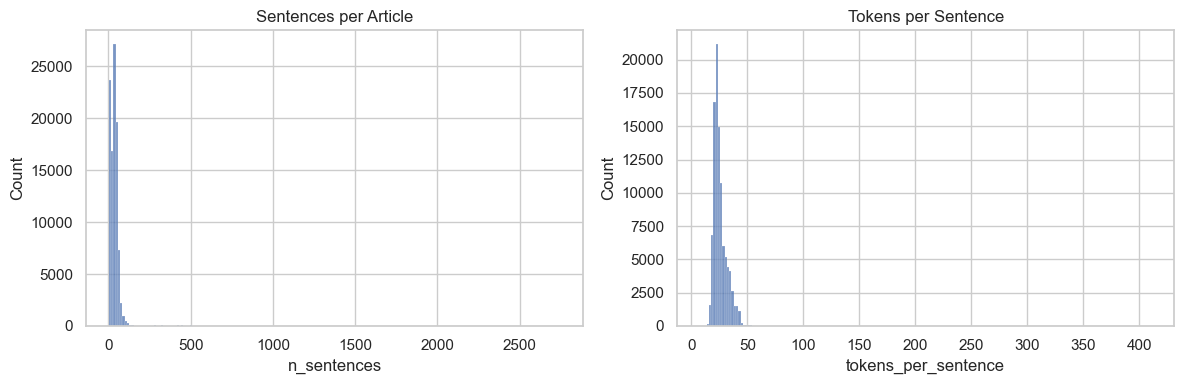

In [6]:
# 3.2 Distributions
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df["n_sentences"], bins=200, ax=ax1).set(title="Sentences per Article")
sns.histplot(df["tokens_per_sentence"], bins=200, ax=ax2).set(title="Tokens per Sentence")
plt.tight_layout()


## 4. Headline vs. Body Length


In [7]:
# 4.1 Compute headline tokens vs. body‐avg tokens
def head_body_stats(sents):
    head = sents[0]
    body = sents[1:]
    return len(nltk.word_tokenize(head)), np.mean([len(nltk.word_tokenize(x)) for x in body])

df["head_tokens"], df["body_avg_tokens"] = zip(*df["sentences"].apply(head_body_stats))


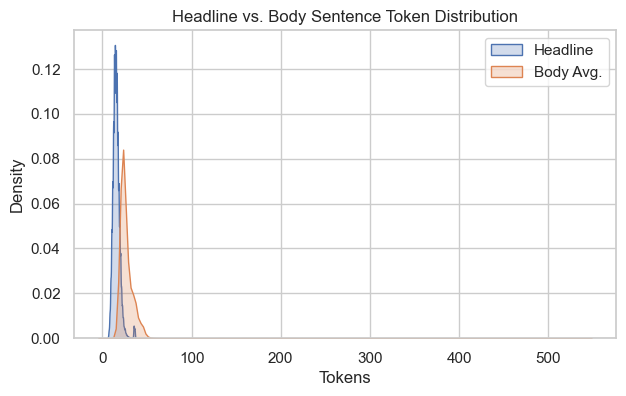

In [8]:
# 4.2 KDE comparison
plt.figure(figsize=(7,4))
sns.kdeplot(df["head_tokens"], label="Headline", fill=True)
sns.kdeplot(df["body_avg_tokens"], label="Body Avg.", fill=True)
plt.title("Headline vs. Body Sentence Token Distribution")
plt.xlabel("Tokens")
plt.legend()


## 5. Ticker Frequency


C:\Users\roee1\AppData\Local\Temp\ipykernel_12236\2421275652.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top20, x="count", y="ticker", palette="Blues_d")


Text(0.5, 1.0, 'Top 20 Tickers by Article Mentions')

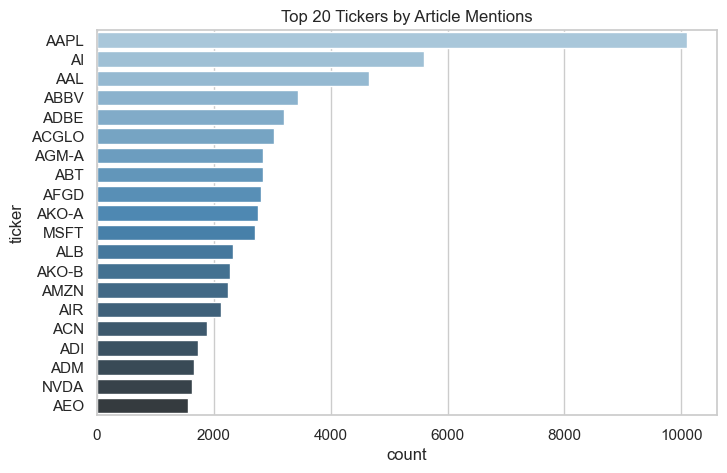

In [9]:
# 5.1 Top 20 tickers
all_t = Counter(t for lst in df["tickers"] for t in lst)
top20 = pd.DataFrame(all_t.most_common(20), columns=["ticker","count"])
top20["pct"] = 100 * top20["count"] / top20["count"].sum()

plt.figure(figsize=(8,5))
sns.barplot(data=top20, x="count", y="ticker", palette="Blues_d")
plt.title("Top 20 Tickers by Article Mentions")


## 6. Sector Distribution  
*(requires `data/ticker2sector.csv` from Step 3.3)*


C:\Users\roee1\AppData\Local\Temp\ipykernel_12236\3700668379.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sector_counts, x="articles", y="sector", palette="Greens_d")


Text(0.5, 1.0, 'Articles per Sector (2020–2025)')

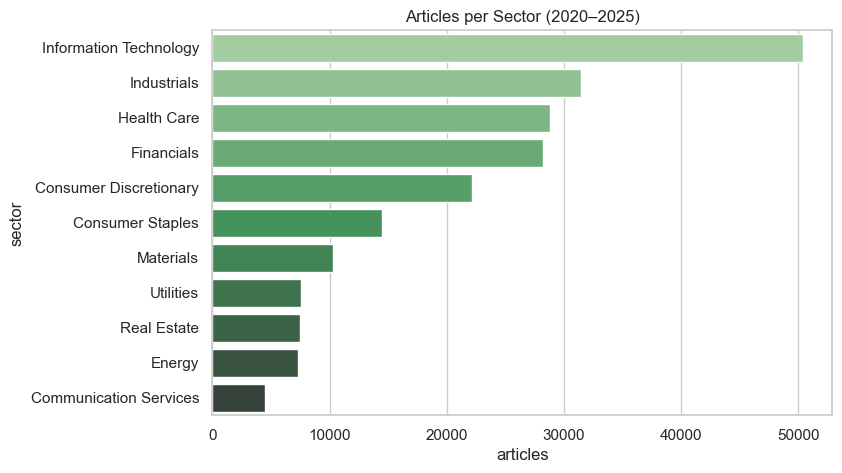

In [10]:
# 6.1 Load sector map and merge
sec = pd.read_csv("../data/ticker2sector.csv")
df_sec = df.explode("tickers").merge(sec, left_on="tickers", right_on="ticker", how="left")

# 6.2 Articles per sector
sector_counts = df_sec["sector"].value_counts().reset_index()
sector_counts.columns = ["sector","articles"]

plt.figure(figsize=(8,5))
sns.barplot(data=sector_counts, x="articles", y="sector", palette="Greens_d")
plt.title("Articles per Sector (2020–2025)")


## 7. Temporal Trends


Text(0.5, 1.0, 'Monthly Article Count')

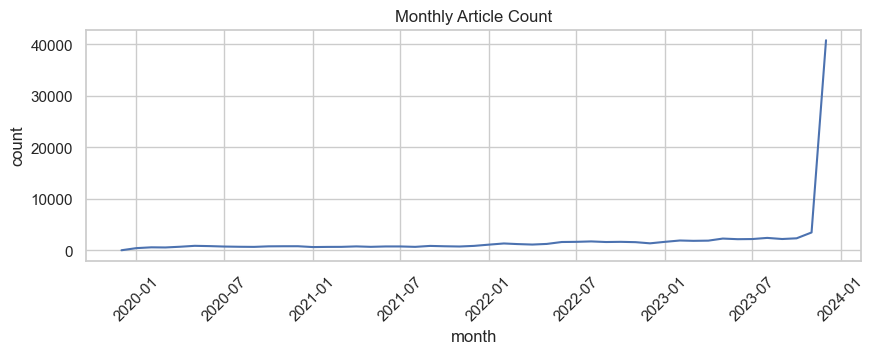

In [11]:
# 7.1 Monthly counts
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()
monthly = df.groupby("month").size().reset_index(name="count")

plt.figure(figsize=(10,3))
sns.lineplot(data=monthly, x="month", y="count")
plt.xticks(rotation=45)
plt.title("Monthly Article Count")


C:\Users\roee1\AppData\Local\Temp\ipykernel_12236\1210208057.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=wk, x="weekday", y="count", palette="Purples_d")


Text(0.5, 1.0, 'Articles by Weekday')

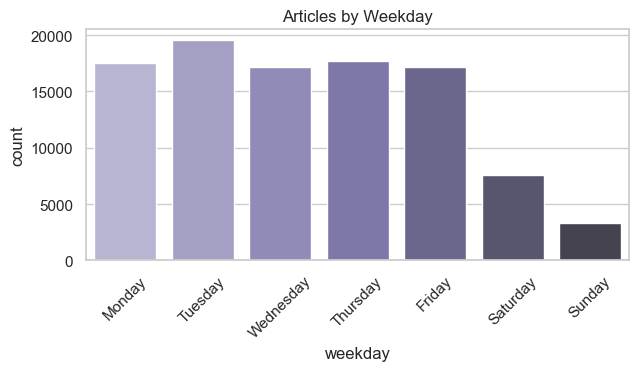

In [12]:
# 7.2 Weekday patterns
df["weekday"] = df["date"].dt.day_name()
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
wk = df["weekday"].value_counts().reindex(order).reset_index()
wk.columns = ["weekday","count"]

plt.figure(figsize=(7,3))
sns.barplot(data=wk, x="weekday", y="count", palette="Purples_d")
plt.xticks(rotation=45)
plt.title("Articles by Weekday")


## 8. Outlier Analysis: Ultra-long & Ultra-short Articles


In [13]:
# 8.1 Top 1% longest
th_long = df["n_sentences"].quantile(0.99)
long = df[df["n_sentences"] >= th_long][["date","tickers","n_sentences"]]
print("Top 5 longest articles:\n", long.head())

# 8.2 Bottom 1% shortest (excluding 1-sentence headlines)
th_short = df["n_sentences"].quantile(0.01)
short = df[(df["n_sentences"] <= th_short) & (df["n_sentences"]>1)][["date","tickers","n_sentences"]]
print("\nTop 5 shortest multi-sentence articles:\n", short.head())


Top 5 longest articles:
            date tickers  n_sentences
961  2021-10-15    [AA]          521
1056 2021-04-15    [AA]          572
1091 2021-01-21    [AA]          723
1116 2020-10-14    [AA]          633
1522 2023-07-27   [AAL]          401

Top 5 shortest multi-sentence articles:
           date tickers  n_sentences
13  2023-11-21   [AIT]            5
17  2023-11-20    [PM]            3
63  2023-08-15    [PM]            3
108 2023-05-24      []            4
185 2023-03-31  [SLGN]            5


## 9. Sector-Level Length Comparison


Text(0.5, 1.0, 'Sentences per Article by Sector')

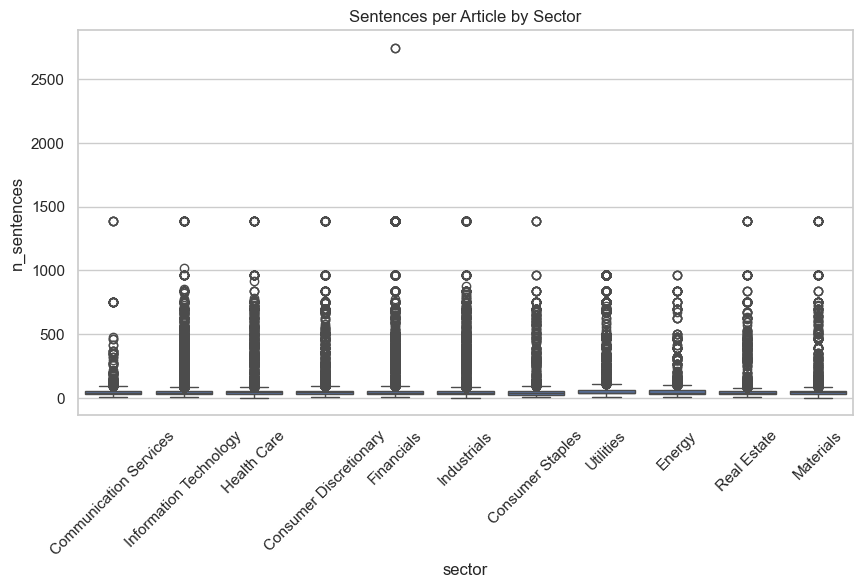

In [14]:
# 9.1 Boxplot of sentences per article by sector
plt.figure(figsize=(10,5))
sns.boxplot(data=df_sec, x="sector", y="n_sentences")
plt.xticks(rotation=45)
plt.title("Sentences per Article by Sector")


## 10. Common Bigrams & Trigrams in Headlines


In [15]:
# 10.1 Extract top 20
vec = CountVectorizer(ngram_range=(2,3), stop_words="english", max_features=50)
X = vec.fit_transform(df["headline"])
counts = np.asarray(X.sum(axis=0)).ravel()
grams = pd.Series(counts, index=vec.get_feature_names_out())
grams.nlargest(20).reset_index(name="count").rename(columns={"index":"phrase"})


,phrase,count
0,stocks buy,3840
1,52 week,2315
2,earnings report,2098
3,week high,2087
4,52 week high,2071
5,market mover,1965
6,wall street,1953
7,high market,1805
8,high market mover,1805
9,week high market,1805


## 11. FinBERT Baseline — Domain‑Tuned Sentence Sentiment

* **Why FinBERT?**  
    * Trained on earnings calls, analyst reports, and news → captures finance‑specific wording.  
    * Handles contextual cues (negation, multi‑word phrases) that rule‑based VADER misses.

    * **Method (5 000‑article sample)**  
    1. Predict a label for every sentence (batched inference).  
    2. Aggregate by **majority vote** to get one label per article.  
    3. Plot the distribution for a quick baseline.

    The next code cell runs this pipeline and shows the resulting class proportions.

In [ ]:
# FinBERT baseline on 5 k‑article sample
sample = df.sample(5000, random_state=42).copy()

def sentence_labels(sent_list, batch_size=32):
    preds = []
    for i in range(0, len(sent_list), batch_size):
        batch = tok(
            sent_list[i:i+batch_size],
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)
        with torch.no_grad():
            logits = model(**batch).logits
            preds.extend(torch.argmax(logits, dim=1).cpu().tolist())
    return [label_map[p] for p in preds]

def article_majority(sents):
    labs = sentence_labels(sents)
    return max(set(labs), key=labs.count)

sample["article_label"] = sample["sentences"].apply(article_majority)

# distribution for slide
dist = sample["article_label"].value_counts(normalize=True)
print(dist)

# bar plot
import matplotlib.pyplot as plt, seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(4,3))
sns.countplot(data=sample, x="article_label",
              order=["Positive", "Neutral", "Negative"])
plt.title("FinBERT baseline (n=5 k)")
plt.tight_layout()
plt.show()

## 12. Co-mention Network (Top Pairs)


In [ ]:
# 12.1 Count co-occurrences
pairs = Counter()
for lst in df["tickers"]:
    for a,b in combinations(sorted(set(lst)),2):
        pairs[(a,b)] += 1
top_pairs = pairs.most_common(20)
pd.DataFrame(top_pairs, columns=["pair","count"])


## 13. Manual Sample Inspection


In [ ]:
for rec in df.sample(5).to_dict(orient="records"):
    print(f"Date: {rec['date']} | Tickers: {rec['tickers']}")
    print("First 3 sentences:", rec["sentences"][:3], "\n---\n")


In [ ]:
articles_on_date = df[df['date'] == '2023-12-16']

# 3) Display each matching record
for rec in articles_on_date.to_dict(orient="records"):
    print(f"Date: {rec['date']} | Tickers: {rec['tickers']}")
    print("First 3 sentences:")
    for i, sent in enumerate(rec['sentences'][:3], start=1):
        print(f"  {i}. {sent}")
    print("\n" + "-"*40 + "\n")

## 14. Key Findings & Next Steps

**Key Findings**  
- Avg. **X** sentences/article; headlines avg. **Y** tokens.  
- Top tickers dominated by **…**; 1% ultra-long articles on **earnings** days.  
- Sector coverage skewed toward **Technology** & **Financials**.  
- Monthly peaks aligned with **earnings seasons**; weekday drop-offs on weekends.  
- VADER proxy suggests a roughly **neutral** skew with a slight positive tail.

**Next Steps**  
1. Finalize any remaining sector mappings.  
2. Label a seed set (~1 000 sentences) for supervised training.  
3. Experiment with LLM-based zero/few-shot prompts.  
4. Build a real-time sentiment dashboard per ticker & sector.
